# Real Time Myo

Display myo data in real time.

Uses simple threading to do data acqusition while plotting on the main thread so we *hopefully* don't miss any data.

## Concept for get_emg_data
Inside seperate thread we have a double ended queue, data comes in from the right up to the maximum queue length. When the main thread wants it we return all the data since the last time it called then remove that data from the internal buffer.

This could be done more effeciently with a circular buffer (since we'd remove the need to pop data out) however deques are well implemented and should run appropriately fast on modern processors.

## Concept for get_emg_ref
Cut out the middle-man and just get a reference to the original deque for use with plotting.

## Notes
* Need to have Myo Connect running otherwise you get random errors
* Use a deque to store EMG data between calls from the main thread
    * Can return data since last acqusition from main thread
    * Alternative can be directly referenced
    * Defaults to storing max 200 samples (1 second of data)
    
## Data Rate Limit
You may run into issues with data rate limitation while running this script in Jupyter. To fix this:
* Use `jupyter notebook --generate-config` if you haven't already made a config file
* Open the `jupyter_notebook_config.py` file likely under `Users/username/.jupyter`
* Add `c.NotebookApp.iopub_data_rate_limit = 10000000` to the bottom which is 10x the default

In [1]:
%matplotlib inline
%matplotlib notebook

import collections
import myo
import threading
import time
import matplotlib.pyplot as plt
import numpy as np

myo.init()  # Init doesn't like being rerun

Paired
Connected


<IPython.core.display.Javascript object>


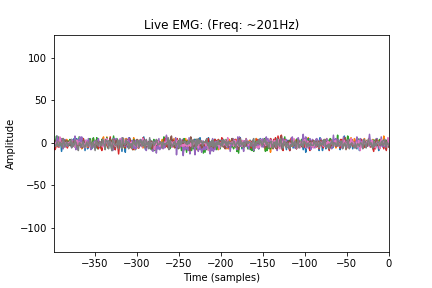

Connected


In [ ]:
class MyoListener(myo.DeviceListener):
    def __init__(self, queue_size=200):
        self.lock = threading.Lock()
        self.emg_data_queue = collections.deque(maxlen=queue_size)
        
    def on_pair(self, myo, *args):
        print("Paired")

    def on_connect(self, device, timestamp, firmware_version):
        print("Connected")
        device.set_stream_emg(myo.StreamEmg.enabled)
        
    def on_arm_sync(self, myo, *args):
        print("Arm Synced")

    def on_emg_data(self, device, timestamp, emg_data):
        with self.lock:
            # Store as tuples, adding from the right
            self.emg_data_queue.append((timestamp, emg_data))  # Timestamp is in ms

    def get_emg_data(self):
        with self.lock:
            data = list(self.emg_data_queue)
            nb_samp = len(data)
            for _ in range(nb_samp):
                self.emg_data_queue.popleft()  # Remove from left
            return data
        
    def get_emg_ref(self):
        with self.lock:
            return self.emg_data_queue


buffer_len = 400  # Plot 2 seconds of data at a time
hub = myo.Hub()
try:
    listener = MyoListener(buffer_len)
    hub.run(100, listener)
    
    fig, ax = plt.subplots()
    plt.ion()  # Live display
    fig.show()
    fig.canvas.draw()
    
    emg_data_ref = listener.get_emg_ref()  # Just use a reference to the internal buffer
    while True:
        ax.clear()
        ax.set_title('Live EMG')
        ax.set_ylabel('Amplitude')
        ax.set_xlabel('Time (samples)')
        ax.set_ylim([-128, 127])  # 8 bit ADC
        ax.set_xlim([-buffer_len + 1, 0]) 
        
        raw_data = list(emg_data_ref)
        nb_datapoints = len(raw_data)
        
        emg_data = [x[1] for x in raw_data]  # Grab EMG data from list of tuples
        x_time = range(-nb_datapoints + 1, 1)
        
        if nb_datapoints > 0:
            timestamp_end = raw_data[-1][0]
            timestamp_start = raw_data[0][0]
            freq = nb_datapoints / (timestamp_end - timestamp_start) * 1000000 # Timestamp in ms
            ax.set_title("Live EMG: (Freq: ~{:.0f}Hz)".format(freq))
            
        else:
            ax.set_title('Waiting for Connection')
        
        ax.plot(x_time, emg_data)
        
        fig.canvas.draw()
        
finally:
    print("Finished")
    hub.shutdown()  # Otherwise the other thread will keep going